[0 1 2 3 4 5]
masks (5, 360, 640)
label:  1 name: Vehicle
label:  1 name: Vehicle
label:  1 name: Vehicle
label:  1 name: Vehicle
label:  4 name: Road


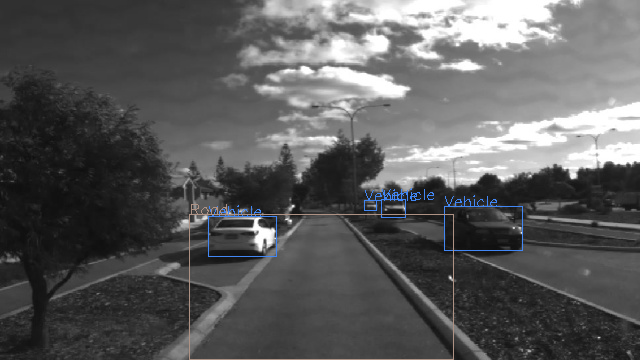

In [25]:
from PIL import Image
import yaml
import os
import numpy as np
from label_manager import LabelManager
import label_manager
import torch
import cv2

obj_entity_list = []
obj_entity_list.append({'Entity': 'Background', 'ID': 0, 'Colour': [0,0,0]})

with open("object.yaml", 'r') as file:
    config = yaml.safe_load(file)
    for ele in config['DRIVING_objects']:
        entity_map = {}
        entity_map['Entity'] = ele['Entity']
        entity_map['ID'] = ele['ID']
        entity_map['Colour'] = ele['Colour']
        obj_entity_list.append(entity_map)




label_mgr = LabelManager()
idx = 0
in_img = Image.open('input/{}.jpg'.format(idx))
mask_img = Image.open('mask/{}.png'.format(idx))
mask = np.array(mask_img)

labels = label_manager.parse_label('mask/{}.yaml'.format(idx))

colour_list = []
for i, entity in enumerate(obj_entity_list):
    cur_colour = entity['Colour']
    colour_list+=cur_colour
    if (i >= len(labels) + 1):
        break


obj_ids = np.unique(mask)
# first id is the background, so remove it
print(obj_ids)
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
print('masks', masks.shape)
num_objs = len(obj_ids)
img_array = np.array(in_img)

boxes = []
out_img = np.zeros((in_img.height, in_img.width, 4), np.uint8)
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
    pt1 = tuple((xmin, ymin))
    pt2 = tuple((xmax, ymax))

    label = labels[i]
    colour = label_mgr.get_colour(label)
    name = label_mgr.get_names()[label - 1]
    print('label: ', label, 'name:', name)

    cv2.rectangle(img_array, pt1, pt2,color=colour, thickness=1)
    cv2.putText(img_array,name, pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour,thickness=1)




updated_img = Image.fromarray(img_array)
updated_img
